#Libraries and Dates

In [1]:
# install libraries
!pip install yfinance
!pip install tfcausalimpact

In [2]:
# import libraries
import pandas as pd

import yfinance as yf
from causalimpact import CausalImpact

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Dates
training_start = "2020-09-01"
training_end = "2020-10-19"
treatment_start = "2020-10-20"
treatment_end = "2020-10-23"
end_stock = "2020-10-24"

#Loading financial data

In [6]:
# Download historical Bitcoin data (adjusted close prices) using yfinance
y = ["BTC-USD"]  # Ticker symbol for Bitcoin in USD
y = yf.download(tickers=y,
                start=training_start,  # Start date for historical data
                end=end_stock,         # End date for historical data
                interval="1d")         # Daily interval

# Select adjusted close prices and rename column to 'y'
y = y['Adj Close'].rename("y")

# Display the first row of the data
y[:1]

[*********************100%%**********************]  1 of 1 completed


Date
2020-09-01    11970.478516
Name: y, dtype: float64

In [7]:
# Load other historical stock data
stocks = ["ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG"]
X = yf.download(tickers=stocks,
                start=training_start,  # Start date for historical data
                end=end_stock,         # End date for historical data
                interval="1d")         # Daily interval

[*********************100%%**********************]  8 of 8 completed


#Data Preparation

In [9]:
# Preview DataFrame X
X.head(1)

Price       Adj Close                                               \
Ticker           CRSP          DE       GOOG         JD       KTOS   
Date                                                                 
2020-09-01  93.419998  206.946274  82.941116  77.058533  19.700001   

Price                                     Close              ...       Open  \
Ticker              SQ   TRMB ZAL.DE       CRSP          DE  ...       TRMB   
Date                                                         ...              
2020-09-01  166.660004  53.41   77.0  93.419998  217.690002  ...  52.669998   

Price                    Volume                                               \
Ticker         ZAL.DE      CRSP         DE        GOOG          JD      KTOS   
Date                                                                           
2020-09-01  74.959999  779500.0  1873400.0  36506000.0  11431400.0  587600.0   

Price                                     
Ticker              SQ      TRMB  ZAL.DE  
Date                                      
2020-09-01  12306400.0  542300.0  790198  

[1 rows x 48 columns]

In [10]:
# Getting the adjusted close
X = X.iloc[:, :len(stocks)]
X.head(1)

Price       Adj Close                                               \
Ticker           CRSP          DE       GOOG         JD       KTOS   
Date                                                                 
2020-09-01  93.419998  206.946274  82.941116  77.058533  19.700001   

Price                                 
Ticker              SQ   TRMB ZAL.DE  
Date                                  
2020-09-01  166.660004  53.41   77.0

In [11]:
#Removing level
X.columns = X.columns.droplevel()
X.head(1)

Ticker,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,
2020-09-01,93.419998,206.946274,82.941116,77.058533,19.700001,166.660004,53.41,77.0


In [12]:
# Remove timezone information from the DataFrame index
X.index = X.index.tz_localize(None)  # Localize index to None, effectively removing timezone info
X.index

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23'],
              dtype='datetime64[ns]', name='Date', freq='B')

In [13]:
# Combine everything, drop null values
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-01,11970.478516,93.419998,206.946274,82.941116,77.058533,19.700001,166.660004,53.410000,77.000000
2020-09-02,11414.034180,93.930000,206.394882,86.315781,77.731133,19.910000,162.880005,54.310001,77.000000
2020-09-03,10245.296875,85.690002,200.405807,81.998695,73.835701,19.520000,152.860001,50.900002,75.080002
2020-09-04,10511.813477,82.019997,200.909653,79.461578,74.732491,19.260000,146.389999,49.959999,71.739998
2020-09-08,10131.516602,81.459999,199.863937,76.532410,71.201378,19.230000,139.110001,49.139999,73.440002


#Data Analysis section


In [16]:
# Prepare a dataframe with only training data
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-10-19,11742.037109,107.720001,227.193573,76.64328,75.302322,20.639999,186.960007,51.970001,85.0


In [17]:
## The Augmented Dickey-Fuller (ADF) test checks if a time series is stable over time, meaning its main properties don't change.
## If the test p-value is below alpha level, it means the time series is stationary.

# Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x=df_training.y)[1]  # Run ADF test on the 'y' column of df_training and get the p-value

# how to read - if/else
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is not stationary


In [18]:
# Perform differencing by calculating the percentage change to make the time series stationary
differencing = df_training.pct_change().dropna()  # Calculate percentage change and drop NA values
differencing.head(2)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.002664,0.040687,0.008728,0.010660,-0.022681,0.016851,0.000000
2020-09-03,-0.102395,-0.087725,-0.029018,-0.050015,-0.050114,-0.019588,-0.061518,-0.062788,-0.024935


In [19]:
# Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x=differencing.y)[1]  # Run ADF test on the 'y' column of df_training and get the p-value

# how to read - if/else
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is stationary


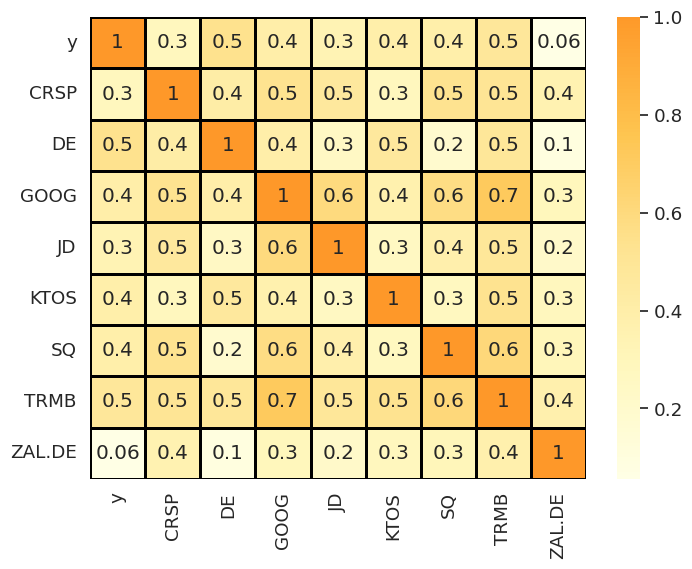

In [ ]:
# Plot a heatmap of the correlation matrix for the differenced data
plt.figure(figsize=(8, 6))  # Set the figure size
sns.set(font_scale=1.2)  # Set the font scale for better readability

sns.heatmap(differencing.corr(),  # Compute and plot the correlation matrix
            annot=True,            # Annotate each cell with correlation value
            fmt='.1g',             # Format for the annotation text
            cmap='YlOrBr',         # Colormap for the heatmap
            center=True,           # Center the colormap at a value (usually 0)
            linewidth=1,           # Width of the lines that will divide each cell
            linecolor='black')     # Color of the lines that will divide each cell

plt.show()  # Display the plot


#Causal Impact


Causal Impact analysis is a statistical technique used to measure the effect of a specific intervention or event on a time series of data.

It helps determine whether a change has had a significant impact by comparing the observed data with a predicted counterfactual.

In [20]:
# Drop column 'ZAL.DE'
df_final = df.drop(columns = ["ZAL.DE"])
df_final.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,206.946274,82.941116,77.058533,19.700001,166.660004,53.41


In [21]:
# Define Pre and Post Period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


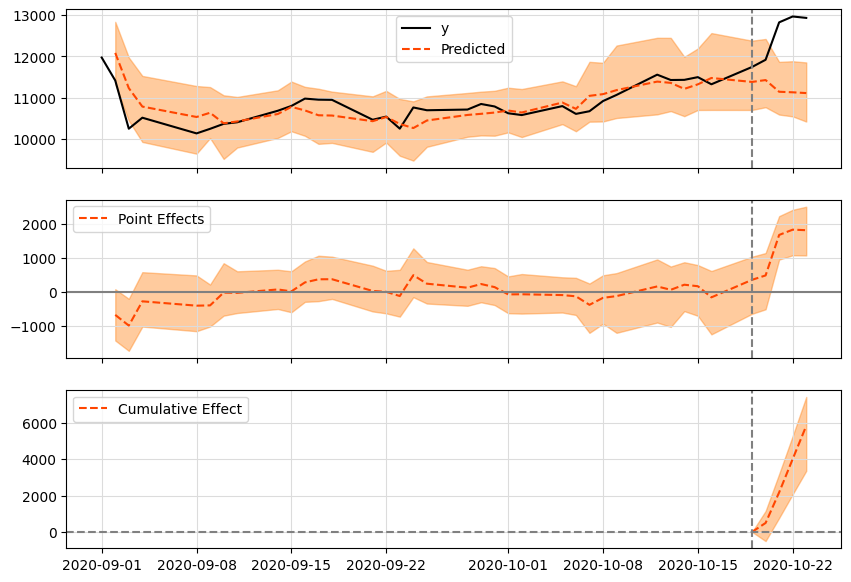

In [22]:
# Apply the Google Causal Impact analysis to the data
impact = CausalImpact(data=df_final,          # Data containing the time series
                      pre_period=pre_period,  # Period before the intervention
                      post_period=post_period) # Period after the intervention

# Plot the results of the Causal Impact analysis
impact.plot()

In [23]:
# Summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11200.58 (229.41)  44802.31 (917.65)
95% CI                    [10798.42, 11697.7][43193.69, 46790.8]

Absolute effect (s.d.)    1458.79 (229.41)   5835.14 (917.65)
95% CI                    [961.66, 1860.94]  [3846.66, 7443.76]

Relative effect (s.d.)    13.02% (2.05%)     13.02% (2.05%)
95% CI                    [8.59%, 16.61%]    [8.59%, 16.61%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.8%

For more details run the command: print(impact.summary('report'))


In [24]:
# Summary report
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11200.58.
The 95% interval of this counterfactual prediction is [10798.42, 11697.7].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1458.79 with a 95% interval of
[961.66, 1860.94]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 44802.31. The 95% interval of this prediction is [43193.69, 46790.8].


The above results are given in terms of absolute numbers. In relative
ter